# Slime Mould Simulation

Harrison Mueller - 22732927

### Setup
#### Libraries

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os

#### Classes

In [2]:
from london_tube import LondonTubeData
from gradient import Gradient
from slime import SlimeNetwork
from mst import MST
from performance import Performance

from sigmoid import make_sigmoid_functions

#### Constants

In [14]:
DIR = "data"
FILES = {"stations": "london.stations.csv", 
         "connections": "london.connections.csv",
         "lines": "london.lines.csv"}
RESULTS = "results/results.csv"

# plots folder
PLOT_DIR = "results/plots"
if not os.path.exists(PLOT_DIR): os.makedirs(PLOT_DIR)

R = 6371 # earth radius in km

# Walk-through with zones = 1

## Load London Tube Data

`Tottenham Court Road` is chosen as the initial station as it is centralised.

id                                         259
latitude                               51.5165
longitude                               -0.131
name                      Tottenham Court Road
display_name    Tottenham<br />Court<br />Road
zone                                       1.0
total_lines                                  2
rail                                         0
Name: 259, dtype: object


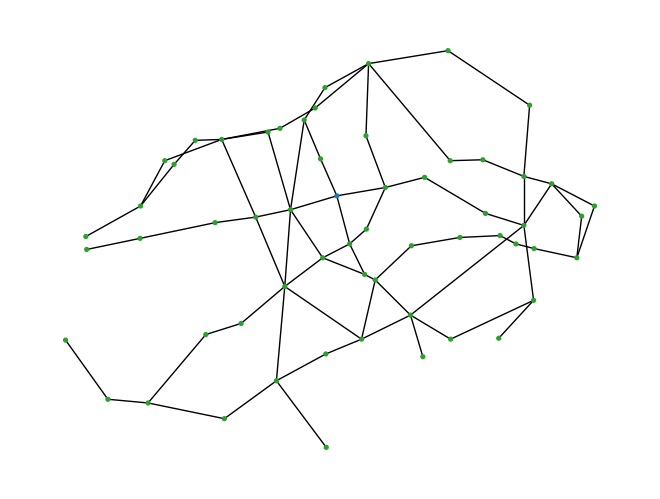

In [4]:
ltdat = LondonTubeData(DIR, FILES)

# initial station
ltdat.set_init(id = 259, prior_subsetting = True)
print(ltdat.init)

# subset 5 zones, plot, and save figure
ltdat.subset(zones = 5)
ltdat.plot(colour_by_zone = True, node_size = 30, 
           filename = os.path.join(PLOT_DIR, "london_tube.png"))
plt.close()

# subset 1 zone
ltdat.subset(zones = 1)
ltdat.plot(colour_by_zone = False, node_size = 30)

### Number of Stations in First $i$ Zones

zone
1.0      60
1.5      64
2.0     139
2.5     156
3.0     203
3.5     209
4.0     247
5.0     275
5.5     276
6.0     294
6.5     295
7.0     297
8.0     299
9.0     300
10.0    302
Name: id, dtype: int64


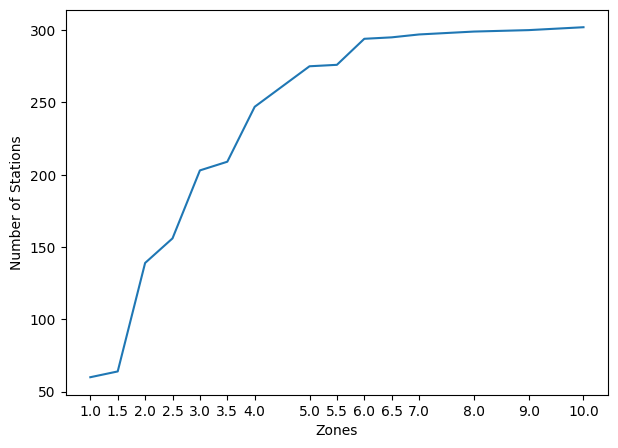

In [5]:
zones = np.unique(ltdat.raw_data.stations.zone)

# number of stations in first i zones
x = ltdat.raw_data.stations.groupby("zone").id.count()
for i in range(1, len(x)):
    x.iloc[i] = x.iloc[i-1]+x.iloc[i]
print(x)
    
fig, ax = plt.subplots(figsize=(7, 5))    

# plot zones
plt.plot(zones, x)

# x axis
plt.xlabel("Zones")
plt.xticks(zones)

# y axis
plt.ylabel("Number of Stations")

plt.savefig(os.path.join(PLOT_DIR, "num_stations.png"), dpi = 300, bbox_inches='tight')
plt.show()

## Slime Simulation

### Sigmoid function
$$
f(x) = \frac{1}{1 + \exp(-c_1 * (x - c_2)}
$$

In this case, $c1  = -3$ and $c2 = 1$.

In [6]:
inv_sigmoid, sigmoid = make_sigmoid_functions(-3,1)

### Establish Gradient

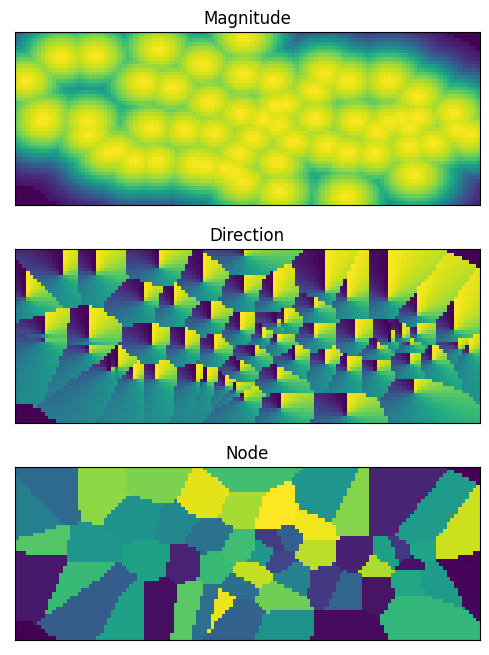

In [7]:
# running with a resolution of 1e-3 here so as it runs quickly
# in `run.py`, I used 1e-4
grad = Gradient(ltdat.G, res = 0.001, border_dist = [1e-3, 2e-3], func = sigmoid, t = sigmoid(2))
grad.plot()

### Grow slime

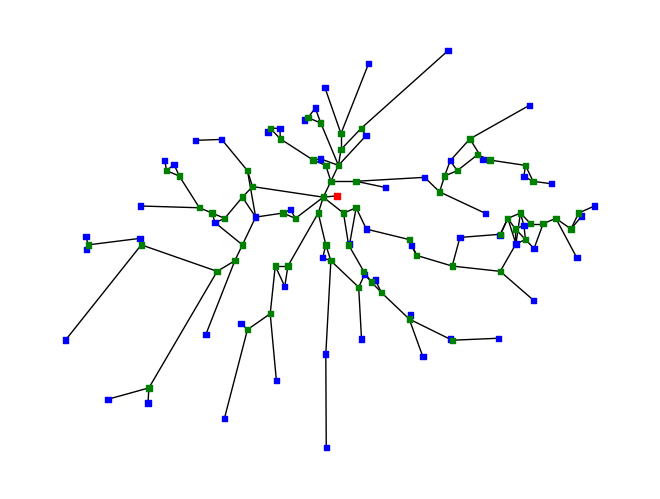

In [8]:
# initialise
slime = SlimeNetwork(ltdat.G, ltdat.init["id"])

# set gradient and config
slime.set_gradient(grad)
slime.set_config(seed = 3141, growth_dist = 0.2, seeing_dist = 0.2, border_dist = [1e-3, 2e-3], 
                 R = R, accuracy = 5, dist_measure = "Haversine")

# grow, trim and plot
slime.grow(n_branches = 10, n_attempts = 20, until_connected = True, verbose = False)
slime.trim()
slime.plot()

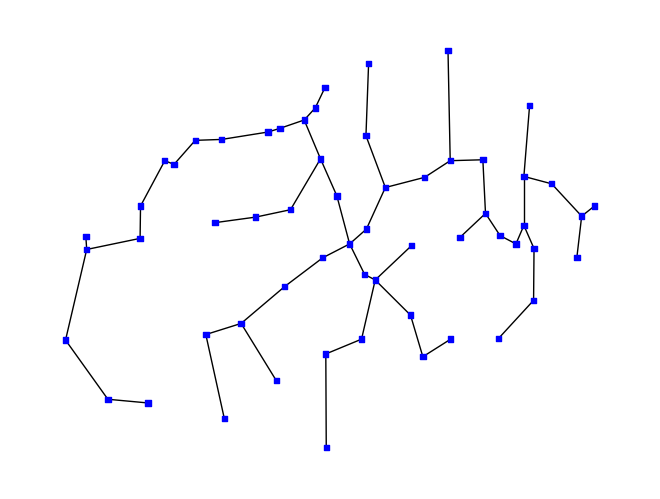

In [9]:
mst = MST(ltdat.G, ltdat.init["id"])
mst.add_all_edges()
mst.apply_mst()
mst.plot()

## Calculate Performance Metrics

 - **Cost**: Total path length
 - **Travel Time**: Average path length between nodes
 - **Vulnerability**: Average increase in travel time after removing edge

In [10]:
p = Performance(slime.G, "Slime Mould")
p.print()

Cost = 63.254836
Travel Time = 4.426328
Vulnerable Edges = 60
Redundant Edges = 97 (+0.021771)
Prop of Vulnerable Edges = 0.382166


In [11]:
p = Performance(ltdat.G, "London Tubes")
p.print()

Cost = 72.693041
Travel Time = 4.659539
Vulnerable Edges = 9
Redundant Edges = 70 (+0.077701)
Prop of Vulnerable Edges = 0.113924


In [12]:
p = Performance(mst.G, "MST")
p.print()

Cost = 37.695113
Travel Time = 5.820271
Vulnerable Edges = 58
Redundant Edges = 0 (+nan)
Prop of Vulnerable Edges = 1.000000


# Full Results

In [15]:
# load data
df = pd.read_csv(RESULTS)

# get proportion of vulnerable edges
df["v_prop"] = df.v_edges / (df.v_edges + df.r_edges)

In [16]:
def get_averages(df: pd.DataFrame, use_gradient: bool):
    """
        Computes the average of the several slime network runs and returns a dataframe
    """
    if use_gradient: mask = df.other == "gradient"
    else: mask = df.other != "gradient"
    # subset df
    s = df[(df.name == "Slime Mould") & mask]
    s1 = s.iloc[0]
    
    # calc averages
    avg = s[["time", "cost", "ttime", "v_edges", "r_edges", "v_prop", "mean_increase"]].mean()

    new_s = pd.DataFrame([{
        "name": "%s%s" % (s1["name"], " (gradient)" if use_gradient else ""),
        "run": "NaN",
        "time": avg.time,
        "zones": s1.zones,
        "other": s1.other,
        "cost": avg.cost,
        "ttime": avg.ttime,
        "v_edges": avg.v_edges,
        "r_edges": avg.r_edges,
        "mean_increase": avg.mean_increase,
        "v_prop": avg.v_prop
    }])
    return new_s.astype(dtype = {
        "name": str,
        "run" : str,
        "time": np.double,
        "zones": np.double,
        "other": str,
        "cost": np.double,
        "ttime": np.double,
        "v_edges": int,
        "r_edges": int,
        "mean_increase": np.double,
        "v_prop": np.double
    })

In [18]:
# get averages
averages = df[df.name.isin(["London Tubes", "MST"])]
for z in np.unique(df.zones):
    averages = pd.concat([averages, get_averages(df[df.zones == z], True), get_averages(df[df.zones == z], False)])

averages = averages.reset_index(drop = True)
    
# drop unneeded columns
averages.drop(columns = ["run", "v_edges", "r_edges", "other"])

,name,time,zones,cost,ttime,mean_increase,v_prop
0,London Tubes,NaN,1.0,72.693041,4.659539,0.077701,0.113924
1,MST,0.004051,1.0,37.695113,5.820271,NaN,1.000000
2,London Tubes,NaN,1.5,80.547449,4.771734,0.076449,0.022989
3,MST,0.004439,1.5,41.083330,6.189910,NaN,1.000000
4,Slime Mould (gradient),56.957123,1.0,60.412222,4.265530,0.029919,0.417788
5,Slime Mould,41.616641,1.0,67.914986,4.128497,0.032684,0.375873
6,Slime Mould (gradient),96.312360,1.5,68.617286,4.464356,0.047998,0.362368
7,Slime Mould,241.263161,1.5,70.947339,4.463550,0.026498,0.405187


## Plotting

In [19]:
# colour-blind friendly graphs - not strictly necessary but good practise
colours = {
    "London Tubes": "#D81B60",
    "MST": "#1E88E5",
    "Slime Mould": "#FF7C07",
    "Slime Mould (gradient)": "#004D40",
}
markers = {
    "London Tubes": "x",
    "MST": ".",
    "Slime Mould": "s",
    "Slime Mould (gradient)": "^",
}

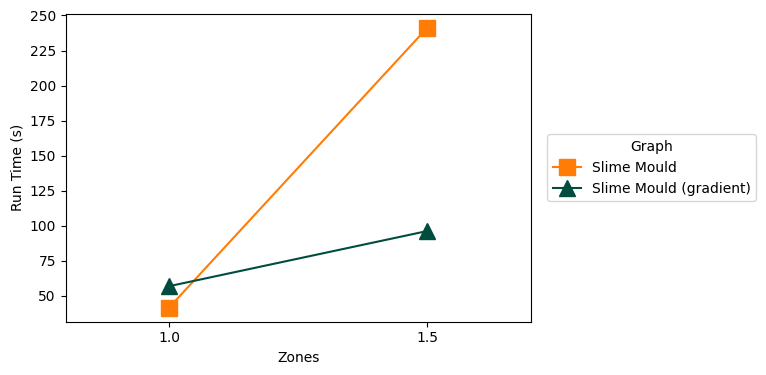

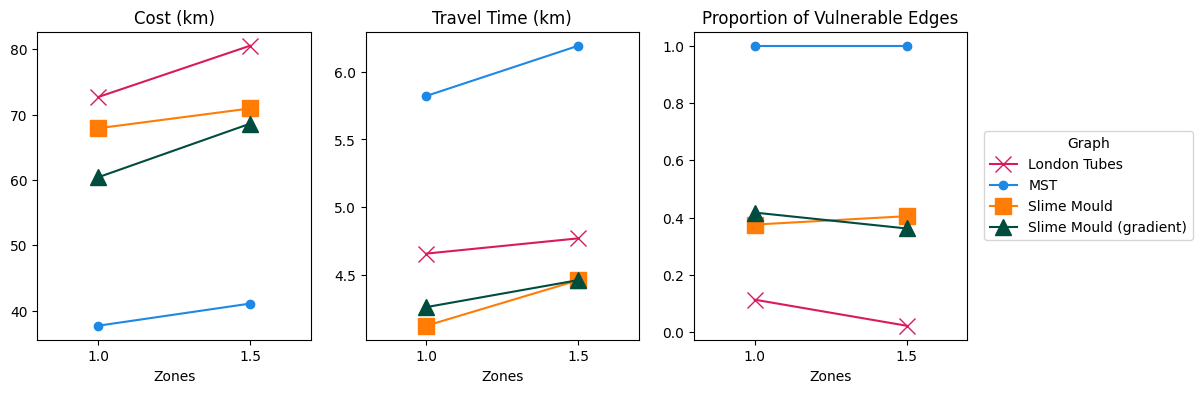

In [20]:
def plot_res(df: pd.DataFrame, var: list, ylim = None, ylab = None, legend = True, filename = None, 
             title = None, bbox = None, figsize = None):
    groups = df.groupby("name")
    
    fig, ax = plt.subplots(1,len(var))
    if figsize: fig.set_size_inches(*figsize)

    # for each plot
    for i in range(len(var)):
        a = ax if len(var) == 1 else ax[i]
        a.margins(0.05)
        
        # plot each group
        for name, group in groups:
            a.plot(group.zones, group[var[i]], marker=markers[name], ms=12, label=name, color = colours[name])

        # title
        if title: a.set_title(title[i])
            
        # x-axis
        a.set_xticks(np.unique(df.zones))
        a.set_xlabel("Zones")
        a.set_xlim(np.min(df.zones)-0.2, np.max(df.zones)+0.2)
    
        # y-axis
        if ylim: a.set_ylim(ylim)
        if ylab: a.set_ylabel(ylab[i])
        
    # legend
    if legend:
        a.legend(title = "Graph", loc = "center right", bbox_to_anchor = bbox)
    
    if filename: plt.savefig(filename, dpi = 300, bbox_inches='tight')
    plt.show()
    
plot_res(averages[averages.name.isin(["Slime Mould", "Slime Mould (gradient)"])], ["time"], 
         ylab = ["Run Time (s)"], bbox = (1.5,0.5), figsize = (6,4),
         filename = os.path.join(PLOT_DIR, "run_time.png"))
plot_res(averages, var = ["cost","ttime", "v_prop"], 
         title = ["Cost (km)", "Travel Time (km)", "Proportion of Vulnerable Edges"], 
         legend = True, bbox = (1.85,0.5), figsize = (12,4),
         filename = os.path.join(PLOT_DIR, "metrics.png"))

## Sigmoid Function
Plotting sigmoid function

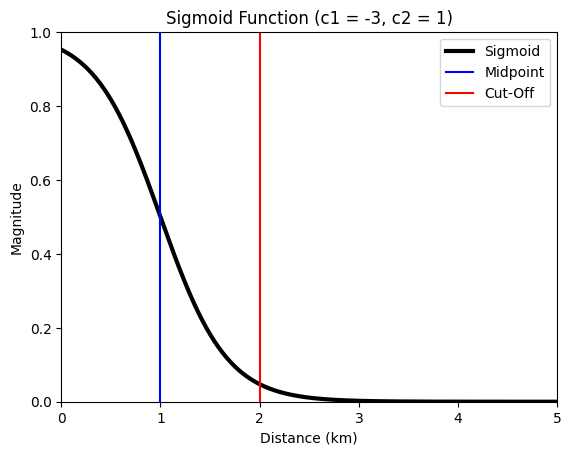

In [21]:
# calculate magnitude
inv_sigmoid, sigmoid = make_sigmoid_functions(-3,1)
xs = np.arange(-1,5,0.01)
ys = [sigmoid(a) for a in xs]

# plot
plt.plot(xs, ys, color = "black", label = "Sigmoid", lw = 3)

# lines
plt.axvline(x = 1, color = "blue", label = "Midpoint")
plt.axvline(x = 2, color = "red", label = "Cut-Off")

# fill between lines
#plt.fill_between(xs, 0, ys, where = xs < 2, lw=2, alpha=0.5)

# limits
plt.ylim(0,1)
plt.xlim(0,5)

# legend
plt.legend()

# labels
plt.xlabel("Distance (km)")
plt.ylabel("Magnitude")

plt.savefig(os.path.join(PLOT_DIR, "sigmoid.png"), dpi = 300, bbox_inches='tight')

# title
plt.title("Sigmoid Function (c1 = -3, c2 = 1)")
plt.show()